# 前提

テーマ : 音声の超解像

データ : VCTK-Corpus 

今回はVCTK-Corpusに収録されている44250個うち, 42250データをtrain data, 残りをvalid dataとして学習する. これらはサンプリングレート48kHzであるが, 今回は実用性と学習時間短縮のため, 8kHzにダウンサンプリングした後, それを16kHzに超解像することを目標とする. すなわち, 入力のサンプリングレートを8kHz, 正解データのサンプリングレートを16kHzとする.

アルゴリズム : CNN

# 後に使う関数の定義

In [1]:
import wave
import scipy as sp
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display
import os
from scipy.io.wavfile import write
import time
import torch
from torch.nn import functional as F
import glob
import transformers


def down_sample_16000(wave):
    w = signal.resample(wave, len(wave)//3, t=None, axis=0, window=None, domain='time')
    w = np.array(w, dtype=np.int16) # 戻しておかないとすごい音がする
    return w

def down_sample_8000(wave):
    w = signal.resample(wave, len(wave)//6, t=None, axis=0, window=None, domain='time')
    w = np.array(w, dtype=np.int16) # 戻しておかないとすごい音がする
    return w


def cubic(waveform):
    waveform = torch.tensor([[[(waveform/ 32768).tolist()]]]) 
    waveform_bi = F.interpolate(waveform, (1,  2 * len(waveform[0][0][0])), mode='bicubic', align_corners=False)
    waveform_bi = waveform_bi * 32768
    x_numpy = waveform_bi.to('cpu').detach().numpy()
    x_numpy = x_numpy.astype(np.int16)
    waveform_bicubic = torch.from_numpy(x_numpy)
    waveform_bicubic = x_numpy[0][0][0]
    return waveform_bicubic

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [76]:
def calculate_loss(model, criterion, dataloader):
    loss = 0
    k = 0
    model.eval()
    with torch.no_grad():
        for inputs, outputs in dataloader:
            #inputs = inputs.to(device)
            #labels = labels.to(device)
            model_out = model(inputs)
            loss += criterion(model_out, outputs)
            k += 1
    return loss/k

def train_model(dataset_train, dataset_valid, batch_size, model, loss, optimizer, num_epochs):
    #dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
    dataloader_valid = DataLoader(dataset_valid, batch_size = batch_size, shuffle = False)
    scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, (len(dataset_train)//batch_size)*2, (len(dataset_train)//batch_size)*num_epochs)
    #scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, (len(dataset_train)//batch_size)*2, (len(dataset_train)//batch_size)*num_epochs, 3)
    lrs = []
    for i in range(num_epochs):
        start = time.time()
        model.train()
        loss_train_m = 0
        j = 0
        for X, Y in dataloader_train: #X:32*64
            optimizer.zero_grad()
            out = model(X)
            out = out.to(device)
            l_train = loss(out, Y)
            l_train.backward()
            optimizer.step()
            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler.step()
            
        loss_train = calculate_loss(model, loss, dataloader_train)
        loss_valid = calculate_loss(model, loss, dataloader_valid)
        end = time.time()
        print('epoch : {0} \n loss_train : {1}, loss_valid : {2}, time : {3}sec'.format(i + 1, loss_train, loss_valid, end - start))
    plt.plot(lrs)
    plt.show()

In [3]:
def get_spectral(angle_a, abs_a):
    return abs_a * (np.cos(angle_a) + 1j * np.sin(angle_a))

In [4]:
def LSD(x, y):
    return (1/x.shape[0])*(((1/x.shape[1])*((x-y)**2).sum(axis=1)) ** 0.5).sum()

In [52]:
def pred_spec_2d(time_size, data_num, net, magnitude, angle, wav_m, wav_name):
    #出力の真ん中部分の採用
    net.eval()
    pred_spectral=[]
    pred_sp = []
    amp = 2 * np.sqrt(2)
    sp_size = 129
    ur = 2
    lengths = min(len(wav_m[data_num]), len(magnitude[data_num]))
    data = magnitude[data_num][:lengths]
    sp_0 = [1e-10]*sp_size
    
    i = 0
    input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = net(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    #最初のdata:32*129のうち前半 1/4部分
    for j in range(time_size//4):
        if j == 0:
            pred_sp.append(sp_0)
        else:
            sp = input_sp[j] + output_sp[j]
            pred_sp.append(sp)

    #中間のdeta:32*129のうち真ん中　2/4部分
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
        input_sp = input_sp.unsqueeze(0)
        output_sp = net(input_sp.to(device))
        input_sp = input_sp.squeeze().tolist()
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size//2):
            sp = input_sp[j + time_size//4] + output_sp[j + time_size//4]
            pred_sp.append(sp)
        i += time_size//2

    #最後のdata:32*129のうち後半 1/4部分
    for j in range(time_size//4):
        sp = input_sp[j + 3 * time_size//4] + output_sp[j + 3 * time_size//4]
        pred_sp.append(sp)

    input_sp = torch.tensor(data)[-time_size:, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = net(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for i in range(len(data)%(time_size//2)):
        sp = input_sp[time_size - len(data)%(time_size//2) + i] + output_sp[time_size - len(data)%(time_size//2) + i]
        pred_sp.append(sp)

    num_pred = np.array(pred_sp)
    
    #LSDの計算
    input_data_up = magnitude[data_num][:lengths, sp_size//ur:]
    lsd_in_label = LSD(input_data_up, wav_m[data_num][:lengths, sp_size//ur:])
    lsd_out_label = LSD(num_pred[:lengths, sp_size//ur:], wav_m[data_num][:lengths, sp_size//ur:])
    
    magnitude_spectrogram = np.exp(num_pred.T) 
    spectral_cnn_2d = get_spectral(angle[data_num][:, :lengths], magnitude_spectrogram)
    spectral_cnn_2d = np.where(np.abs(spectral_cnn_2d) >= amp/10, spectral_cnn_2d, 0)
    _, wav_xrec_2d = signal.istft(spectral_cnn_2d, 16000, nperseg=256, noverlap=64)
    wav_xrec_2d = np.array(wav_xrec_2d, dtype=np.int16) # 戻しておかないとすごい音がする
    
    print('LSD_in_label : {0}, LSD_out_label : {1}'.format(lsd_in_label, lsd_out_label))

    write(wav_name, 16000, wav_xrec_2d)
    
    return IPython.display.Audio(wav_name)

In [6]:
def show_spec(sample_rate, name_wav):
    amp = 2 * np.sqrt(2)    
    wave_file = wave.open(name_wav, 'r')
    length = wave_file.getnframes() #16000*sec
    x = wave_file.readframes(wave_file.getnframes())
    wav_x = np.frombuffer(x, dtype = "int16")
    f, t, Zxx = signal.stft(wav_x[:length], sample_rate, nperseg=256, noverlap = 64)
    
    plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)
    plt.colorbar()
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    return plt.show()

# データの前処理
ここでは, 上で定義した dawn_sample を用いて, wav_down_8000には8kHzの音声, wav_down_16000には16kHzの音声をあらかじめ入れてある.
方針としては, まず上で定義した cubic を用いて, まず8kHzの音声をcubic補間によって16kHzにアップサンプリングする.(フレーム数を合わせるため)

次に, 短時間フーリエ変換によって振幅スペクトルと位相スペクトルに分ける. 

### 工夫1
人間の聴覚特性を考慮し, 振幅スペクトルには対数を取っている. (参照(1))

これらを用いて振幅スペクトルについて CNN を用いて学習する.(一般的に, 音声復元の際に, 位相スペクトルが及ぼす影響は振幅スペクトルに比べてかなり小さいので, 今回は振幅スペクトルのみを学習し, 位相スペクトルはこれを再利用する.)

In [7]:
wav_file = sorted(glob.glob('wav_down_8000/*.wav'))
wav_ori_file = sorted(glob.glob('wav_down_16000/*.wav'))
m_16000 = []
angle_16000 = []
m_ori_16000 = []
data_size = len(wav_file)
i = 0

for wav, wav_ori in zip(wav_file, wav_ori_file):
    wave_8000 = wave.open(wav, 'r')
    wave_ori = wave.open(wav_ori, 'r')
    
    length = wave_8000.getnframes()
    length_ori = wave_ori.getnframes()
    
    x = wave_8000.readframes(length)
    x_ori = wave_ori.readframes(length_ori)
    
    wav_8000 = np.frombuffer(x, dtype = 'int16')
    wav_16000 = np.frombuffer(x_ori, dtype = 'int16')
    
    wav_cubic_16000 = cubic(wav_8000) #cubic補間によってサンプリングレートを16000にする
    
    f_bi, t_bi, Zxx_cubic = signal.stft(wav_cubic_16000[:length*2], 16000, nperseg = 256, noverlap = 64)
    f_ori, t_ori, Zxx_ori = signal.stft(wav_16000[:length_ori], 16000, nperseg = 256, noverlap = 64)
    
    m_16000.append(np.log(np.abs(Zxx_cubic.T) + 1e-10)) #-(1)
    angle_16000.append(np.angle(Zxx_cubic))
    m_ori_16000.append(np.log(np.abs(Zxx_ori.T) + 1e-10))#-(1)
    
    i += 1
    if i == data_size:
        print('end')
        break
    elif i%10000 == 0:
        print(len(m_16000))

10000
20000
30000
40000
end


### 工夫2
スペクトログラムを一枚の写真とみたてて, これから 2DCNN で学習をしていくが, 学習データとして約40000データでは少ない.

そこで, フレームサイズ(time_size)を64, ストライドを32として写真を切り出していく.(時間方向にのみ)

こうすることで, 下でもわかるように376581個まで拡張することができた. (参照(2))

### 工夫3
cubic補間によって入力データの低周波成分はある程度復元されている. ゆえに, 今回は高周波成分のみを学習する.  つまり, スペクトログラムの下半分を入力し上半分を正解として学習, 音声に復元する際は入力と出力を結合する. これにより学習に必要なパラメータを削減し, 学習スピードを高める.

以下では, これらのためのデータの切り分けを行っている.

In [8]:
import tqdm
#cubic補間時のフレーム数のずれ(1フレーム以下)を補正
lengths = [min(len(hf), len(lf)) for hf, lf in zip(m_ori_16000, m_16000)]
sp_size = len(m_16000[0][0])
ur = 2
x_train_2d = []
time_size = 64
stride = 32
train_data_size = 42250
valid_data_size = 2000

#time_sizeよりも小さいdataは捨てる
for n, data in tqdm.tqdm(enumerate(m_16000[:train_data_size])):
    i = 0
    while i < lengths[n] - time_size:
        d = data[i:i + time_size, 0:sp_size//ur]
        x_train_2d.append(d)
        i += stride
    if lengths[n] >= time_size:
        dd = data[lengths[n] - time_size:lengths[n], 0:sp_size//ur]
        x_train_2d.append(dd)
print('end x_train')
    
x_valid_2d = []
for n_v, data in tqdm.tqdm(enumerate(m_16000[train_data_size : train_data_size + valid_data_size])):
    n = train_data_size + n_v
    i = 0
    while i < lengths[n] - time_size:
        d = data[i : i + time_size, 0:sp_size//ur]
        x_valid_2d.append(d)
        i += stride
    if lengths[n] >= time_size:
        dd = data[lengths[n] - time_size:lengths[n], 0:sp_size//ur]
        x_valid_2d.append(dd)
print('end x_valid')

y_train_2d = []
for n, data in tqdm.tqdm(enumerate(m_ori_16000[:train_data_size])):
    i = 0
    while i < lengths[n] - time_size:
        d = data[i : i + time_size, sp_size//ur:]
        y_train_2d.append(d)
        i += stride
    if lengths[n] >= time_size:
        dd = data[lengths[n] - time_size:lengths[n], sp_size//ur:]
        y_train_2d.append(dd)
print('end y_train')
    
y_valid_2d = []
for n_v, data in tqdm.tqdm(enumerate(m_ori_16000[train_data_size : train_data_size + valid_data_size])):
    n = train_data_size + n_v
    i = 0
    while i < lengths[n] - time_size:
        d = data[i : i + time_size, sp_size//ur:]
        y_valid_2d.append(d)
        i += stride
    if lengths[n] >= time_size:
        dd = data[lengths[n] - time_size:lengths[n], sp_size//ur:]
        y_valid_2d.append(dd)
print('end y_valid')

print('データ数 : {0}'.format(len(x_train_2d)))#-(2)

42250it [00:00, 176936.33it/s]
2000it [00:00, 166134.08it/s]
19167it [00:00, 191659.22it/s]

end x_train
end x_valid


42250it [00:00, 184926.32it/s]
2000it [00:00, 170092.22it/s]

end y_train
end y_valid
データ数 : 376581


In [9]:
len(x_train_2d) == len(y_train_2d)

True

In [10]:
len(x_valid_2d) == len(y_valid_2d)

True

In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class Audio(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y) #data数を返す
    
    def __getitem__(self, index):
        return (torch.tensor(self.X[index]).to(device), torch.tensor(self.Y[index]).to(device))
    
# #Datasetの作成        
dataset_train_2d = Audio(x_train_2d, y_train_2d)
dataset_valid_2d = Audio(x_valid_2d, y_valid_2d)

# 学習
モデルの構成は以下の通り.

3層の畳み込み層, 3層の脱畳み込み層, 活性化関数にはLeaky Relu, 各層にBatchNormを用いた.

In [19]:
#Conv -> TransConv -> Linear -> reshape
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64,kernel_size=(2, 4), stride=(2, 2), padding = (1, 2), bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.Lrelu = nn.LeakyReLU(0.2, inplace = True)
        self.conv2 = nn.Conv2d(64, 128,kernel_size=(2, 4), stride=(2, 2), padding =  (1, 2), bias = False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256,kernel_size=(4, 4), stride=(2, 2), padding =  (2, 2), bias = False)
        self.bn3 = nn.BatchNorm2d(256)
    
        self.Tconv1 = nn.ConvTranspose2d(256, 128, (2, 4), (2, 2), padding = (1, 2), bias = False)
        self.Tconv2 = nn.ConvTranspose2d(128, 64, (2, 4), (2, 2), padding = (1, 2), bias = False)
        self.Tconv3 = nn.ConvTranspose2d(64, 1, (2, 4), (2, 2), padding = (1, 2), bias = False)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3364, 64*65)


    def forward(self,x):
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.Lrelu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.Lrelu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.Lrelu(x)
        
        x = self.Tconv1(x)
        x = self.bn2(x)
        x = self.Lrelu(x)
        
        x = self.Tconv2(x)
        x = self.bn1(x)
        x = self.Lrelu(x)
        
        x = self.Tconv3(x)
        x = self.Lrelu(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        x = torch.reshape(x, (x.shape[0], 64, 65))

        return x


### 工夫4, 5
学習の安定のために, 以下のような重みの初期化を用いた.

また, scheduler を用いてより学習の精度を高めた.(def train_model 参照)

In [44]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.005)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn2d = Net()
cnn2d.apply(weights_init)
loss_2d = nn.MSELoss()#平均二乗誤差
optimizer_2d = torch.optim.Adam(cnn2d.parameters(), lr = 1e-5)
cnn2d.to(device)
cnn2d.train()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Tconv1): ConvTranspose2d(256, 128, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (Tconv2): ConvTranspose2d(128, 64, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (Tconv3): ConvTranspose2d(64, 1, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (flatten): Flatten()
  (fc): Linear(in_features=3364, out_features=4160, bias=True)
)

epoch : 1 
 loss_train : 6.633768558502197, loss_valid : 7.2122673988342285, time : 108.41968035697937sec
epoch : 2 
 loss_train : 3.688519239425659, loss_valid : 4.043962001800537, time : 108.92055821418762sec
epoch : 3 
 loss_train : 1.8482407331466675, loss_valid : 1.8268102407455444, time : 113.91848087310791sec
epoch : 4 
 loss_train : 1.6095843315124512, loss_valid : 1.4196441173553467, time : 114.25494074821472sec
epoch : 5 
 loss_train : 1.6070870161056519, loss_valid : 1.4070583581924438, time : 114.23315453529358sec


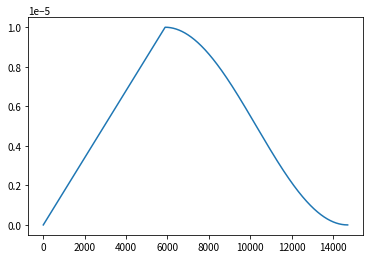

In [47]:
import time
train_model(dataset_train_2d, dataset_valid_2d, 128, cnn2d, loss_2d, optimizer_2d, 5)

# 評価
例としてvalid_dataの一つを見てみる.

### 工夫6
今回, データを入力を64フレームずつ切り取って入力データとしていたため, スペクトログラムを再構成する際には, また64フレームずつ結合していけば良い. しかし, 音声は連続的なものであるため端のフレームは片側のスペクトルが欠落しているために中央付近のフレームと予測に少なからず差が生じると考えた. 

そこで, pred_spec_2d では64フレームのうち真ん中32フレームだけを真の出力と見なし, 32フレームずつ結合することでこれを緩和した. (def pred_spec_2d 参照)

In [71]:
data_number = 40300

**予測したスペクトログラムと音声↓**

In [72]:
pred_spec_2d(time_size = 64, data_num = data_number, net = cnn2d, magnitude = m_16000, angle = angle_16000, wav_m = m_ori_16000, wav_name = 'wav_pred/e.wav')

LSD_in_label : 2.1454129184249546, LSD_out_label : 1.0068370507331792


<ipython-input-6-08ca7a7653de>:9: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)
<ipython-input-6-08ca7a7653de>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


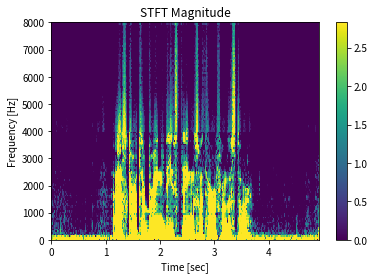

In [73]:
show_spec(sample_rate = 16000, name_wav = 'wav_pred/e.wav')

**正解データ(16kHz)としているスペクトログラムと音声↓**

<ipython-input-6-08ca7a7653de>:9: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)
<ipython-input-6-08ca7a7653de>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


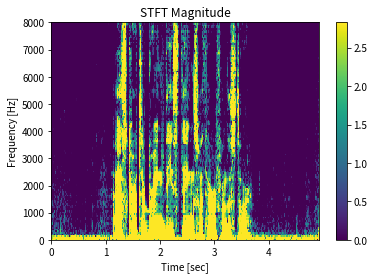

In [83]:
file = sorted(glob.glob('wav_down_16000/*.wav'))
show_spec(sample_rate = 16000, name_wav = file[data_number])
IPython.display.Audio(file[data_number])

**元データ(8kHz)のスペクトログラムと音声↓**

<ipython-input-6-08ca7a7653de>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


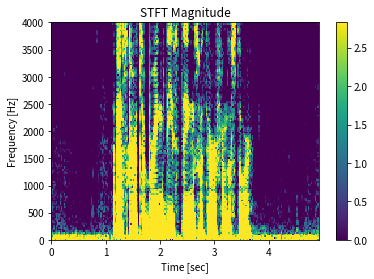

In [82]:
file_8k = sorted(glob.glob('wav_down_8000/*.wav'))
show_spec(sample_rate = 8000, name_wav = file_8k[data_number])
IPython.display.Audio(file_8k[data_number])

# 考察

結果としては, 上に出力したように, 音としてクリアになった. 客観的評価指標としてLSD(Log Spectrogram Distance)も導入し, かなりよくなっていることがわかる.

考察としては, 今回5エポックで学習を終了したが, これは以上学習を続けてしまうと出力が徐々に0に近づいていってしまうからである.

考えられる理由としては, スペクトログラムからわかるように, 音声が無音の部分は正解データも0であり, そのような正解データが少なくない数存在しするため, 損失関数である MSEを下げようとすると, どうしても出力が0に近づいてしまうのだろう.

今後, より精度を上げるにはデータの前処理で正解がほとんど0になってしまうものを取り除く方法も考えられるが, 人力でその割合を調節するのはとても大変だと思う.

ここで, 近年注目されているGANの有用性がよくわかる. 今回のようにただMSEを下げようとして出力を0に近づけているだけだと Discriminatorに簡単に判別されてしまうため, より精度の高い高周波成分の予測が期待できる. 実際に, 近年の音の超解像ではSRGANなどのGANが主流で, さらには今回はスペクトログラムからのみ学習をしたが, 波形とスペクトログラムの両方の観点から学習をすることでより精度の高いモデルを実現している論文もある.

将来, これらの技術を用いて音楽だけでなく, zoomなどの音声もより良いものになることに期待したい.